In [6]:
# Before you use this make sure which pax version are you using

import pax, hax
INFO = """
Pax
version: {pax_version}
build: {pax_file}
Hax
version: {hax_version}
build: {hax_file}
"""

INFO = INFO.format(
pax_version = pax.__version__,
pax_file = pax.__file__,
hax_version = hax.__version__,
hax_file = hax.__file__
)

print(INFO)


Pax
version: 6.10.1
build: /project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pax-6.10.1-py3.4.egg/pax/__init__.py
Hax
version: 2.5.0
build: /project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/__init__.py



In [87]:
import os, sys, time
import numpy as np
from numpy import sqrt, exp, pi, square
import pandas as pd
pd.options.mode.chained_assignment = None        # default='warn'
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d, UnivariateSpline
import warnings
warnings.filterwarnings('ignore')
from multihist import Histdd, Hist1d
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from contextlib import contextmanager

def plt_config(title=None, xlim=None, ylim=None, xlabel=None, ylabel=None, colorbar=False, sci=False, art=plt):
    for field in ['title', 'xlim', 'ylim', 'xlabel', 'ylabel']:
        if eval(field) != None: getattr(art, field)(eval(field))
    if isinstance(sci, str): art.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if isinstance(colorbar,str): art.colorbar(label=colorbar)
    elif colorbar: art.colorbar(label = '$Number\ of\ Entries$')

@contextmanager
def initiate_plot(dimx=24, dimy=9):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    global fig; fig = plt.figure()
    yield
    plt.show()
    
### Plotting ####
params = {
    'backend': 'Agg',
    # colormap
    'image.cmap' : 'viridis',
    # figure
    'figure.figsize' : (4, 2),
    'font.size' : 32,
    'font.family' : 'serif',
    'font.serif' : ['Times'],
    # axes
    'axes.titlesize' : 42,
    'axes.labelsize' : 32,
    'axes.linewidth' : 2,
    # ticks
    'xtick.labelsize' : 24,
    'ytick.labelsize' : 24,
    'xtick.major.size' : 16,
    'xtick.minor.size' : 8,
    'ytick.major.size' : 16,
    'ytick.minor.size' : 8,
    'xtick.major.width' : 2,
    'xtick.minor.width' : 2,
    'ytick.major.width' : 2,
    'ytick.minor.width' : 2,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 12,
    'lines.markeredgewidth' : 3,
    'errorbar.capsize' : 8,
    'lines.linewidth' : 3,
    #'lines.linestyle' : None,
    'lines.marker' : None,
    'savefig.bbox' : 'tight',
    'legend.fontsize' : 24,
    'axes.labelsize': 32,
    'axes.titlesize' : 32,
    'xtick.labelsize' : 25,
    'ytick.labelsize' : 25,
    'xtick.major.pad' : 10,
    'text.latex.unicode': True,
}
plt.rcParams.update(params)
plt.rc('text', usetex=False)
    
if not hax.config:
    hax.init(raw_data_access_mode = 'local',
             raw_data_local_path = ['/project/lgrandi/xenon1t/raw_for_waveforms/'], 
             main_data_paths= ['/project2/lgrandi/xenon1t/processed/pax_v6.10.0/',''])
    datasets = hax.runs.datasets

In [88]:
run_number = 11797
event_number = 10
name = datasets[datasets.number==run_number].name.values[0]

In [49]:
from pax import core
core_processor = core.Processor(config_names=('_base','XENON1T'),
    just_testing=False,
    config_dict={
        'pax':{
            'input_name' : '/project/lgrandi/xenon1t/raw_for_waveforms/%s'%name,
            'events_to_process' : [event_number],
            'output' : 'Dummy.DummyOutput',
            'pre_output' : [],
            'encoder_plugin' : None,
            }}
)

processor MainProcess L66 INFO This is PAX version 6.10.1, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw_for_waveforms/170804_0004/XENON1T-11797-000000000-000000999-000001000.zip (number 1/1 in folder) for reading


In [50]:
events = core_processor.get_events()
event = next(events)
event = core_processor.process_event(event)
core_processor.make_timing_report(1)

In [150]:
import pickle
with open('/project2/lgrandi/zhut/s2_single_classifier_gmix_v6.10.0.pkl', 'rb') as f:
    gmix=pickle.load(f)

def classify(peak, s2):
    if peak.type == 's2':
        for rp in peak.reconstructed_positions:
            if rp.algorithm == 'PosRecTopPatternFit':
                gof = getattr(rp, 'goodness_of_fit')

        Y = np.array([[np.log10(peak.area), np.log10(gof), np.log10(s2.area)]])
        cls = gmix.predict(Y)
        if cls == 1:
            return 'etrain'
        
    return peak.type

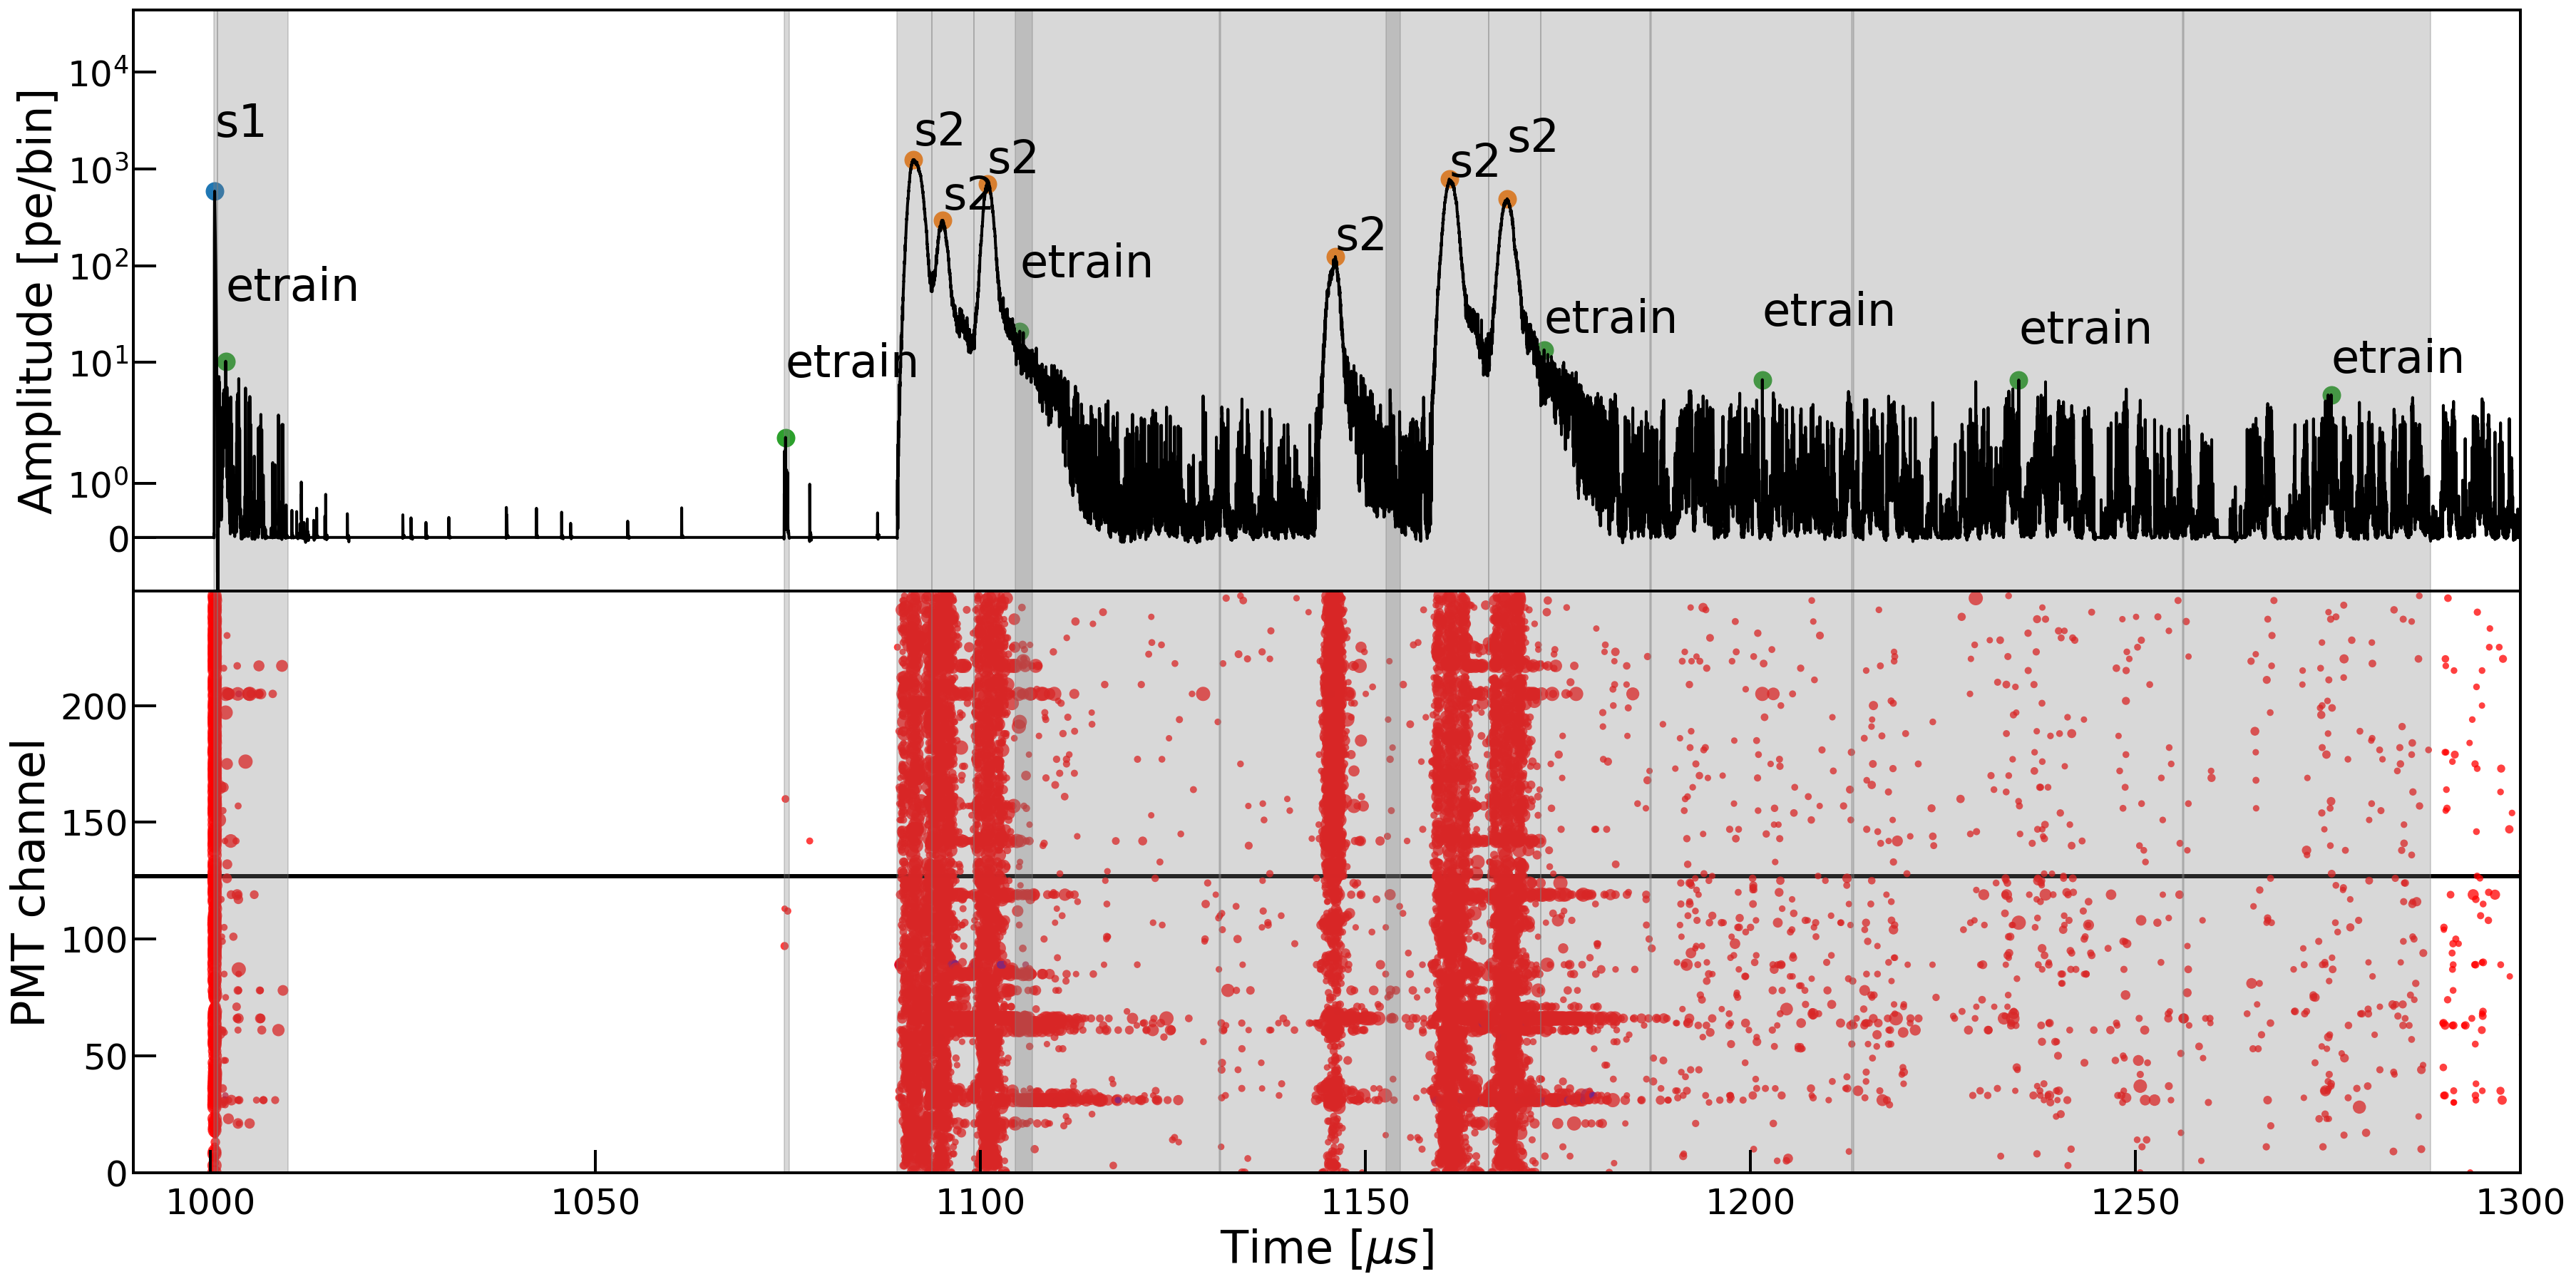

In [157]:
############## Plotting while processing #######################
def hit_color(hits):
    color_factor = np.clip(hits.height/hits.noise_sigma, 0, 15)/15
    is_rejected = hits.is_rejected.astype(int)
    
    rgba_colors = np.zeros((len(hits), 4))
    rgba_colors[:, 0] = (1 - is_rejected) * color_factor
    rgba_colors[:, 1] = is_rejected
    rgba_colors[:, 2] = (1 - is_rejected) * (1 - color_factor)
    rgba_colors[:, 3] = 0.75
    
    return rgba_colors

def plot_3d_waveform(event, xlim):
    global possible_interaction_peaks
    possible_interaction_peaks = []
    
    if len(event.interactions) < 1:
        print('No interaction in this event')
        return 0
    s2 = event.peaks[event.interactions[0].s2]
        
    with initiate_plot(30,15):
        axm = plt.gca()
        axm.tick_params(axis='both', bottom='off', labelbottom='off', left='off', labelleft='off')
        pos = axm.get_position()
        top = [pos.x0, pos.y0+0.5*pos.height, pos.width, pos.height*0.5]
        bot = [pos.x0, pos.y0, pos.width, pos.height*0.5]

        ####################################################
        axt = plt.axes(top)
        w = event.get_sum_waveform('tpc').samples[:]
        time = np.arange(len(w))*0.01

        ymax = np.max(w)**1.5

        plt.yscale('symlog')
        plt.plot(time, w, color='k', lw=2.0)

        plt_config(xlim = xlim, ylim=[-1, ymax], ylabel='Amplitude [pe/bin]')
        axt.tick_params(axis='x', bottom='off', labelbottom='off', left='off', labelleft='off')

        ####################################################
        axb = plt.axes(bot)
        plt.axhline(127, color='k', zorder=0)
        for peak_i, peak in enumerate(event.peaks):
            if peak.detector != 'tpc': continue

            hits = pd.DataFrame(peak.hits)
            hits = hits[(hits.channel<248) & (hits.area>2)]
            axb.scatter(hits.index_of_maximum*0.01, hits.channel, 
                        c=hit_color(hits), edgecolor='none', s=10 * np.clip(hits.area, 0, 10))
            if (peak.area>0) and (peak.type == 's1' or peak.type == 's2'):

                x, y = peak.index_of_maximum*0.01, w[peak.index_of_maximum]
                ytext = np.random.uniform(y, min(ymax, y*5))

                if x>xlim[1] or x<xlim[0]:
                    continue
                axt.axvspan(peak.left*0.01, peak.right*0.01, color='grey', alpha=0.3)
                axb.axvspan(peak.left*0.01, peak.right*0.01, color='grey', alpha=0.3)

                text = classify(peak, s2)
                axt.text(x, ytext, text)

                cmap = dict(s1='C0', s2='C1', etrain='C2')
                axt.scatter(x, y, color=cmap[text])
                
                if text in ['s1', 's2']:
                    possible_interaction_peaks.append(peak)

        plt_config(xlim=xlim, ylim=[0, 249], xlabel='Time [$\mu s$]', ylabel='PMT channel')

plot_3d_waveform(event, xlim=[990, 1300])